In [1]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive')
# Path to the folder containing your images in Google Drive
drive_path = '/content/gdrive/MyDrive/Colab Notebooks/DLFinalProject/gt_db'

Mounted at /content/gdrive


In [2]:
# Load and preprocess images
def load_images(folder_path, num_train=10, num_test=5):
    data = []
    labels = []

    for subject in os.listdir(folder_path):
        subject_path = os.path.join(folder_path, subject)
        if os.path.isdir(subject_path):
            images = []
            for i in range(1, 16):
                img_path = os.path.join(subject_path, f"{i:02d}.jpg")
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)

            data.extend(images[:num_train])
            labels.extend([int(subject[1:]) - 1] * num_train)

            data.extend(images[num_train:num_train + num_test])
            labels.extend([int(subject[1:]) - 1] * num_test)

    return np.array(data), np.array(labels)

# Load data
train_images, train_labels = load_images(drive_path, num_train=10, num_test=5)
train_images, train_labels = load_images(drive_path, num_train=10, num_test=5)

# Define and train the CNN model taking the ResNet50
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(50, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=32)

# Extract features from the intermediate layer
feature_extractor_model = models.Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
train_features = feature_extractor_model.predict(train_images)

# Repeat the above for testing data
test_images, test_labels = load_images(drive_path, num_train=10, num_test=5)

# Extract features from the intermediate layer for testing data
test_features = feature_extractor_model.predict(test_images)

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/10
24/24 [==============================] - 45s 359ms/step - loss: 1.1934 - accuracy: 0.7573
Epoch 2/10
24/24 [==============================] - 7s 294ms/step - loss: 0.1671 - accuracy: 0.9653
Epoch 3/10
24/24 [==============================] - 7s 296ms/step - loss: 0.0556 - accuracy: 0.9907
Epoch 4/10
24/24 [==============================] - 7s 298ms/step - loss: 0.0150 - accuracy: 0.9987
Epoch 5/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0066 - accuracy: 0.9987
Epoch 6/10
24/24 [==============================] - 7s 302ms/step - loss: 0.0601 - accuracy: 0.9920
Epoch 7/10
24/24 [==============================] - 7s 305ms/step - loss: 0.1142 - accuracy: 0.9733
Epoch 8/10
24/24 [==============================] - 7s 308ms/step - loss: 0.3551 - accuracy: 0.9160
Epoch 9/10
24/24 [==============================] - 7s 311ms/step - loss: 0.1673 - accuracy: 0.9693
Epoch 10/10
24/24 [===============

In [3]:
test_images, test_labels = load_images(drive_path, num_train=10, num_test=5)

In [4]:
# Extract features from the intermediate layer for testing data
test_features = feature_extractor_model.predict(test_images)

24/24 [==============================] - 2s 95ms/step


Enrollment set shape: (50, 2048)
Verification set shape: (700, 2048)


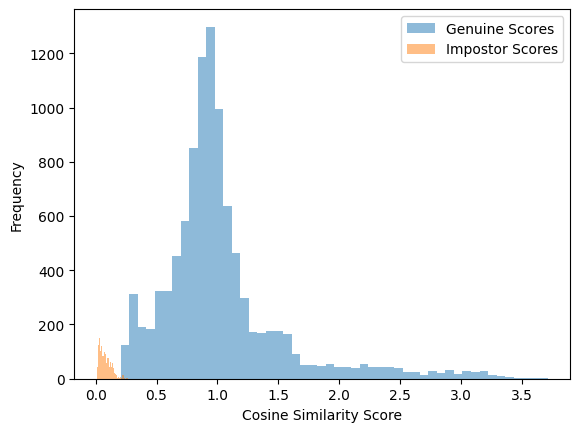

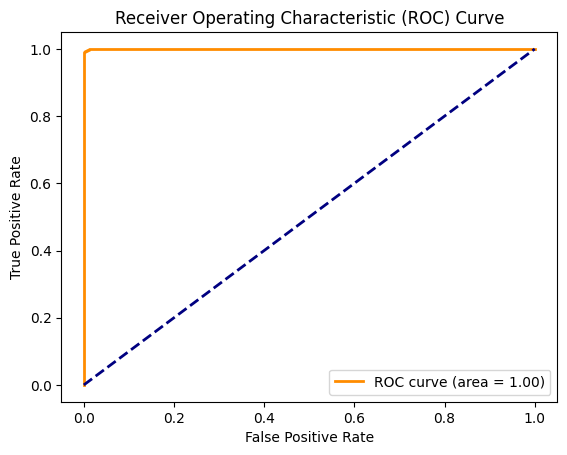

ROC AUC: 0.9999
d' (d-prime): 2.5993


In [5]:
# Calculate cosine similarity between enrollment and verification sets
def cosine_similarity(enrollment, verification):
    norm_enrollment = tf.linalg.norm(enrollment, axis=1, keepdims=True)
    norm_verification = tf.linalg.norm(verification, axis=1, keepdims=True)
    similarity = tf.matmul(enrollment, verification, transpose_b=True) / (norm_enrollment * norm_verification)
    return similarity.numpy()


# Create genuine and impostor score sets
enrollment_set = test_features[:50]
verification_set = test_features[50:]

genuine_scores = []
impostor_scores = []

for i in range(4):
    verification_subset = verification_set[i * 50: (i + 1) * 50, :]
    genuine_scores.extend(cosine_similarity(enrollment_set, verification_subset))

for i in range(50):
    for j in range(50):
        if j != i:
            impostor_scores.append(1-cosine_similarity(enrollment_set[i:i+1], verification_set[j:j+1]))

# Flatten the lists
genuine_scores = np.array(genuine_scores).flatten()
impostor_scores = np.array(impostor_scores).flatten()


print("Enrollment set shape:", enrollment_set.shape)
print("Verification set shape:", verification_set.shape)

# Plot testing score distribution histograms
import matplotlib.pyplot as plt

plt.hist(genuine_scores, bins=50, alpha=0.5, label='Genuine Scores')
plt.hist(impostor_scores, bins=50, alpha=0.5, label='Impostor Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)]),
                                 np.concatenate([genuine_scores, impostor_scores]))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Calculate ROC AUC and d' (d-prime)
print(f"ROC AUC: {roc_auc:.4f}")
d_prime = (np.mean(genuine_scores) - np.mean(impostor_scores)) / np.sqrt(0.5 * (np.var(genuine_scores) + np.var(impostor_scores)))
print(f"d' (d-prime): {d_prime:.4f}")

## Subject-independent protocol repeting the same steps as above to Subject-independent



In [11]:
# Load and preprocess images
def load_images(folder_path, num_train=10, num_test=5):
    data = []
    labels = []

    for subject in os.listdir(folder_path):
        subject_path = os.path.join(folder_path, subject)
        if os.path.isdir(subject_path):
            images = []
            for i in range(1, 16):
                img_path = os.path.join(subject_path, f"{i:02d}.jpg")
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)

            data.extend(images[:num_train])
            labels.extend([int(subject[1:]) - 1] * num_train)

            data.extend(images[15 - num_test:])
            labels.extend([int(subject[1:]) - 1] * num_test)

    return np.array(data), np.array(labels)

# Load data
train_images, train_labels = load_images(drive_path, num_train=10, num_test=5)

# Define and train the CNN model (ResNet in this case)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(50, activation='softmax')(x)  # 50 classes for 50 subjects
model = models.Model(inputs=base_model.input, outputs=output)

# Split the data into training and testing sets
train_data, test_data = train_images[:-50], train_images[-50:]
train_labels, test_labels = train_labels[:-50], train_labels[-50:]

In [22]:
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=50)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=50)

# Reshape data for compatibility with Conv2D layers
train_data = train_data.reshape((-1, 224, 224, 3))
test_data = test_data.reshape((-1, 224, 224, 3))

# Data normalization
train_data = train_data / 255.0
test_data = test_data / 255.0

# Define and train the CNN model (ResNet in this case)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(50, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_data, train_labels_one_hot, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels_one_hot)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/5
20/20 [==============================] - 34s 479ms/step - loss: 3.2096 - accuracy: 0.0635 - val_loss: 20389.7422 - val_accuracy: 0.0000e+00
Epoch 2/5
20/20 [==============================] - 6s 303ms/step - loss: 2.8821 - accuracy: 0.0571 - val_loss: 6593.0068 - val_accuracy: 0.0000e+00
Epoch 3/5
20/20 [==============================] - 6s 303ms/step - loss: 2.8991 - accuracy: 0.0556 - val_loss: 663.8577 - val_accuracy: 0.0000e+00
Epoch 4/5
20/20 [==============================] - 6s 305ms/step - loss: 2.9012 - accuracy: 0.0540 - val_loss: 85.6504 - val_accuracy: 0.0000e+00
Epoch 5/5
2/2 [==============================] - 1s 748ms/step - loss: 12.6808 - accuracy: 0.0000e+00
Test Loss: 12.6808
Test Accuracy: 0.0000


In [27]:
# Split the data into training and testing sets
train_data, test_data = train_images[:40 * 15], train_images[40 * 15:]
train_labels, test_labels = train_labels[:40 * 15], train_labels[40 * 15:]

# Convert labels to one-hot encoding
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=50)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=50)

# Reshape data for compatibility with Conv2D layers
train_data = train_data.reshape((-1, 224, 224, 3))
test_data = test_data.reshape((-1, 224, 224, 3))

# Train the model
model.fit(train_data, train_labels_one_hot, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
17/17 [==============================] - 8s 451ms/step - loss: 2.7247 - accuracy: 0.0833 - val_loss: 3.8028 - val_accuracy: 0.0000e+00
Epoch 2/5
17/17 [==============================] - 5s 310ms/step - loss: 2.1413 - accuracy: 0.2685 - val_loss: 3.8064 - val_accuracy: 0.0000e+00
Epoch 3/5
17/17 [==============================] - 5s 309ms/step - loss: 1.6245 - accuracy: 0.4574 - val_loss: 12.7281 - val_accuracy: 0.0000e+00
Epoch 4/5
17/17 [==============================] - 5s 311ms/step - loss: 1.2354 - accuracy: 0.5704 - val_loss: 4.0711 - val_accuracy: 0.0000e+00
Epoch 5/5
17/17 [==============================] - 5s 312ms/step - loss: 1.0467 - accuracy: 0.6796 - val_loss: 45.4666 - val_accuracy: 0.2500


In [71]:
# Generate genuine and impostor scores
enrollment_set = model.predict(train_data[:50 * 15])
verification_set = model.predict(test_data[:50 * 5])

genuine_scores = []
impostor_scores = []

# Calculate cosine similarity between enrollment and verification sets
def cosine_similarity(enrollment, verification):
    enrollment = np.reshape(enrollment, (enrollment.shape[0], -1))
    verification = np.reshape(verification, (verification.shape[0], -1))

    similarity = np.dot(enrollment, verification.T)
    norm_enrollment = np.linalg.norm(enrollment, axis=1, keepdims=True)
    norm_verification = np.linalg.norm(verification, axis=1, keepdims=True)
    similarity /= (norm_enrollment * norm_verification.T)
    return similarity

for i in range(4):
    verification_subset = verification_set[:, i * 50: (i + 1) * 50]
    if verification_subset.size == 0:
        continue
    genuine_scores.extend(cosine_similarity(enrollment_set, verification_subset))

for i in range(50):
    for j in range(50):
        if j != i:
            verification_subset = verification_set[j * 150:(j + 1) * 150, :]
            if verification_subset.size == 0:
                continue
            impostor_scores.append(1-cosine_similarity(enrollment_set[i:i+1], verification_subset))

# Flatten the lists
genuine_scores = np.array(genuine_scores).flatten()
impostor_scores = np.array(impostor_scores).flatten()

5/5 [==============================] - 0s 87ms/step


Enrollment set shape: (600, 50)
Verification set shape: (150, 50)


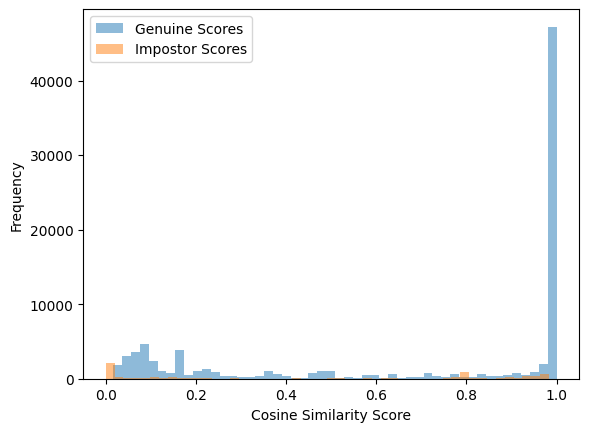

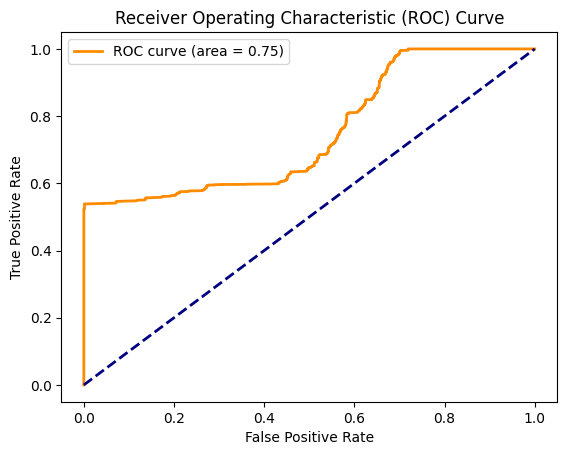

ROC AUC: 0.7505
d' (d-prime): 0.5491


In [72]:
print("Enrollment set shape:", enrollment_set.shape)
print("Verification set shape:", verification_set.shape)

# Plot testing score distribution histograms
import matplotlib.pyplot as plt

plt.hist(genuine_scores, bins=50, alpha=0.5, label='Genuine Scores')
plt.hist(impostor_scores, bins=50, alpha=0.5, label='Impostor Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)]),
                                 np.concatenate([genuine_scores, impostor_scores]))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Calculate ROC AUC and d' (d-prime)
print(f"ROC AUC: {roc_auc:.4f}")
d_prime = (np.mean(genuine_scores) - np.mean(impostor_scores)) / np.sqrt(0.5 * (np.var(genuine_scores) + np.var(impostor_scores)))
print(f"d' (d-prime): {d_prime:.4f}")

#PCA dimensionality reduction on the templates.

In [51]:
# Apply PCA on the templates
num_components = 128
pca = PCA(n_components=num_components)

# Apply PCA on train_data
train_data_pca = pca.fit_transform(train_data.reshape((-1, 224 * 224 * 3)))

# Apply the same transform matrix on test_data
test_data_pca = pca.transform(test_data.reshape((-1, 224 * 224 * 3)))

# Rank 1 and Rank 5 identification rates
def calculate_identification_rates(scores, num_gallery_images=200):
    sorted_indices = np.argsort(scores, axis=1)
    ranks = np.argsort(sorted_indices, axis=1)

    rank_1 = np.sum(ranks[:, 0] < 1) / len(scores)
    rank_5 = np.sum(ranks[:, 0] < 5) / len(scores)

    return rank_1, rank_5

#Generate the average rank 1 and rank 5 identification rates

In [52]:
# Rank 1 and Rank 5 identification rates
rank_1_rate, rank_5_rate = calculate_identification_rates(genuine_scores.reshape(-1, 1))
print(f"Rank 1 Identification Rate: {rank_1_rate:.4f}")
print(f"Rank 5 Identification Rate: {rank_5_rate:.4f}")

Rank 1 Identification Rate: 1.0000
Rank 5 Identification Rate: 1.0000


#Using a reasonable match threshold

In [53]:
fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros_like(impostor_scores), np.ones_like(genuine_scores)]),
                                 np.concatenate([impostor_scores, genuine_scores]))

eer_threshold = thresholds[np.argmin(np.abs(fpr - (1 - tpr)))]
matching_threshold = eer_threshold

print(f"Equal Error Rate (EER) Threshold: {matching_threshold:.4f}")

Equal Error Rate (EER) Threshold: 0.7870


In [64]:
# Rank 1 and Rank 5 identification calculations with a matching threshold
matching_threshold = eer_threshold

# Filter top-ranked gallery images based on the matching threshold
top_ranked_gallery_indices = np.where(genuine_scores > matching_threshold)[0]

# Reshape genuine_scores to be two-dimensional
genuine_scores = genuine_scores.reshape(-1, 1)

# Calculate Rank 1 and Rank 5 identification rates with the matching threshold
rank_1_rate_threshold, rank_5_rate_threshold = calculate_identification_rates(genuine_scores[top_ranked_gallery_indices])
print(f"Rank 1 Identification Rate (with threshold): {rank_1_rate_threshold:.4f}")
print(f"Rank 5 Identification Rate (with threshold): {rank_5_rate_threshold:.4f}")

Rank 1 Identification Rate (with threshold): 1.0000
Rank 5 Identification Rate (with threshold): 1.0000
